In [1]:
from IPython.core.display import HTML
HTML("<style>.container { width:95% !important; }</style>")

# Lecture 4: unconstrained optimization- gradient-based methods


## Optimization problem to be studied

We are still studying functions of multiple variables in unconstrained optimization problems
$$
\begin{align}
\min \quad &f(x)\\
\text{s.t.}\quad &x\in \mathbb R^n
\end{align}  
$$

## Let us define the same function as on the previous lecture for testing

$$
\begin{align}
\min \quad & (x_1-10)^2+(x_2+5)^2+x_1^2\\
\text{s.t.}\quad &x_1,x_2\in\mathbb R
\end{align}  
$$

In [2]:
def f_simple(x):
    return (x[0] - 10.0)**2 + (x[1] + 5.0)**2+x[0]**2

## Reminder: Model algorithm for unconstrained minimization (an iterative approach)

 Let $x_k$ be the current approximation for a local minimum $x^*$:
 
* (1) **Check the convergency** If conditions are satisfied, stop. The solution is $x_k$.

* (2) **Identify a search direction**  Find a nonzero vector $d_k \in \mathbb R^n$ as a search direction.

* (3) **Identify a step length** Find an $\alpha_k > 0$ as a step length, for which $f(x_k + \alpha_k d_k) < f(x_k)$ (i.e., leads us to a better approximation)

* (4) **Update the current approximation for the local minimum** Set $x_{k+1} = x_k + \alpha_k d_k, k =  k + 1$ and go to (1).


## Gradient-based optimization

If gradients are available, they should always be used --> improve convergency

Gradient-based methods usually converge to a local minimum which is nearest to the starting point 

If analytical formulas of the gradients are not available, one way is to numerically approximate them by using finite differences ($ℎ>0$)
* forward difference: $\frac{f(x+h)-f(x)}{h}=\nabla f(x)+O(h)$
* central difference: $\frac{f(x+h)-f(x-h)}{2h}=\nabla f(x)+O(h^2)$
* central difference is more accurate but requires twice as many function evaluations (in $𝑥+ℎ$ and $𝑥−ℎ$)

## Automatic differentiation in Python

An alternative way is to use automatic differentiation

https://en.wikipedia.org/wiki/Automatic_differentiation

Import automatic differentiation package for Python

There are various packages, e.g., "ad", "autograd", "tensorflow", "torch", etc. But I used "ad" (in mind that it might not be compatible with some other packages as it has not been updated since 2015).

Needs to be installed typing
```
(!) pip install ad   (or autograd)


You can ask for gradient and hessian using the <pre>ad.gh</pre> function.

 Let us use automatic differentiation for the function <it>f</it>  that we defined.

In [3]:
import ad
grad_f, hess_f = ad.gh(f_simple)

In [4]:
print("At the point (1,2) gradient is ", grad_f([1,2]), " and hessian is ", hess_f([1,2]))

At the point (1,2) gradient is  [-16.0, 14.0]  and hessian is  [[4.0, 0.0], [0.0, 2.0]]


### Let us visualize the gradient

In [5]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from pylab import meshgrid
def visualize_gradient(f,point,x_lim,y_lim):
    grad_point = np.array(ad.gh(f)[0](point)) # computes the gradient
    grad_point = 10.0*grad_point/np.linalg.norm(grad_point) # scale the gradient vector so that it is easier to see
    X,Y,Z = point[0],point[1],f(point) # point that we are interested in and the function value in that point 
    U,V,W = grad_point[0],grad_point[1],0 # gradient vector, last component is zero since the gradient has 2 components
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d') 
    x = np.arange(x_lim[0],x_lim[1],0.1) # divide interval for x
    y = np.arange(y_lim[0],y_lim[1],0.1) # divide interval for y
    X2,Y2 = meshgrid(x, y) # make a grid for x and y
    Z2 = [f([x,y]) for (x,y) in zip (X2,Y2)] # evaluation of the function on the grid
    Z2 = np.asarray(Z2)
    surf = ax.plot_surface(X2, Y2, Z2,alpha=0.5) # surface plot for the function values
    ax.quiver(X,Y,Z,U,V,W,color='red',linewidth=2.5) # plots a 2d arrow in a 3d figure
    return plt
    

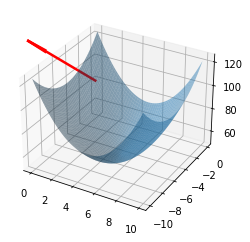

In [62]:
visualize_gradient(f_simple,[1,-2],[0,10],[-10,0]).show()

With the lambda function we can easily visualize gradients of various functions without a user-defined function

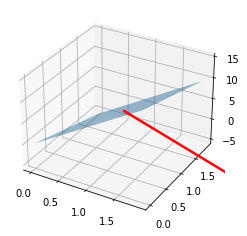

In [61]:
import math 
visualize_gradient(lambda x:8*x[0]-3*x[1],[1,1],[0,2],[0,2]).show()

# Gradient-based Methods


## Steepest descent and Newton's method

### Reminder: Model algorithm for unconstrained minimization (an iterative approach)

Let $x_k$ be the current approximation for a local minimum $x^*$:
 
* (1) **Check the convergency** If conditions are satisfied, stop. The solution is $x_k$.

* (2) **Identify a search direction**  Find a nonzero vector $d_k \in \mathbb R^n$ as a search direction.

* (3) **Identify a step length** Find a $\alpha_k > 0$ as a step length, for which $f(x_k + \alpha_k d_k) < f(x_k)$ (i.e., leads us to a better approximation)

* (4) **Update the current approximation for the local minimum** Set $x_{k+1} = x_k + \alpha_k d_k, k =  k + 1$ and go to (1).


## Base algorithm for the steepest descent and Newton's algorithms
**Input:** function $f$ to be optimized, starting point $x_0$, step length rule $alpha$, stopping rule $stop$  
**Output:** A solution $x^*$ that is close to a locally optimal solution
```
set f_old as a big number and f_new as f(x0)
while a stopping criterion has not been met:
    f_old = f_new
    determine search direction d_k according to the method
    determine the step length alpha
    set x = x + alpha *d_k
    f_new = f(x)
return x
```

The way to determine search direction distinguishes steepest descent algorithm and the Newton algorithm. Different stopping rules and step sizes can be mixed and matched with both algorithms.

When moving along the gradient direction from any point to n-dimensional space, the function values change at the **fastest rate**.

## Steepest Descent algorithm for unconstrained optimization

Also known as *gradient descent* or *gradient method*

## Desent direction:

* If $d_k$ is a descent direction for $f$ at $x_k$: $f(x_{k+1}) < f(x_k) $.

So, if $x_{k+1} = x_k + \alpha_k d_k$:

* $\rightarrow  f(x_k + \alpha_k d_k) < f(x_k)$ 

Using Taylor series expansion of $f$:

* $\rightarrow  f(x_k) + \alpha_k ( \nabla f(x_k) . d_k) < f(x_k) $ 


* $\rightarrow \alpha_k ( \nabla f(x_k) . d_k) < 0 $, ($\alpha_k > 0$)


* $\rightarrow \nabla f(x_k) . d_k < 0 $ (**condition for the descent direction**)

## Steepest Descent algorithm for unconstrained optimization

Also known as *gradient descent* or *gradient method*

In the steepest descent algorithm, the search direction $d_k$ is determined by the negative of the gradient $-\nabla f(x_k)$ which (locally) gives the direction of the steepest descent of $f$ at point $x_k$.

* $x_{k+1} = x_k - \alpha_k \nabla f(x_k)$

 Indeed, the objective function decreases fastest in $x_k$ (you can check it out yourself using the condition for the descent direction if you are interested)
 
 * Very simple example of a univariant function
 ![](images/2d-grad-desc.jpg)
 

 An example of a function with two variables:
 
 ![](images/2d-grad-desc1.jpg)

Another example of a function with two variables:
 
 ![](images/2d-grad-desc2.jpg)

### Code in Python

Let us use a simple stopping rule, where we stop when the change is not bigger than precision and we have a fixed step size.

In [11]:
import numpy as np
import ad
def steepest_descent(f,start,step,precision):
    f_old = float('Inf')
    x = np.array(start)
    steps = []
    f_new = f(x)
    while abs(f_old-f_new)>precision:
    #while np.linalg.norm(ad.gh(f)[0](x))>precision: # an alternative stopping rule
        f_old = f_new # store value at the current point
        d = -np.array(ad.gh(f)[0](x)) # search direction
        x = x+d*step # take a step
        f_new = f(x) # compute function value at the new point
        steps.append(list(x)) # save step
    return x,f_new,steps

### Solve the problem using the Python function

In [58]:
start = [2.0,-10.0]
step_size = 0.1
precision = 0.01
(x_value,f_value,steps) = steepest_descent(f_simple,start,step_size,precision)
print("Optimal solution is ",x_value)
print(len(steps))
print(steps)

Optimal solution is  [ 4.9994922  -5.11258999]
17
[[3.2, -9.0], [3.92, -8.2], [4.352, -7.56], [4.6112, -7.048], [4.76672, -6.6384], [4.860032, -6.31072], [4.9160192, -6.048576], [4.94961152, -5.8388608], [4.969766912, -5.67108864], [4.9818601472, -5.5368709119999995], [4.98911608832, -5.429496729599999], [4.993469652992, -5.34359738368], [4.9960817917952, -5.274877906944], [4.9976490750771205, -5.2199023255552], [4.998589445046273, -5.17592186044416], [4.999153667027763, -5.140737488355328], [4.999492200216658, -5.1125899906842625]]


Plot the steps of solving

In [59]:
import matplotlib.pyplot as plt

def plot_2d_steps(steps,start):
    myvec = np.array([start]+steps).transpose()
    #print(myvec)
    plt.plot(myvec[0,],myvec[1,],'ro')
    for label,x,y in zip([str(i) for i in range(len(steps)+1)],myvec[0,],myvec[1,]):
        plt.annotate(label,xy = (x, y))
    return plt

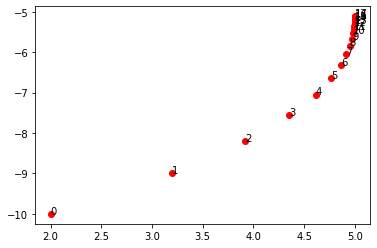

In [60]:
plot_2d_steps(steps,start).show()

## Other stopping rules
* change in function values: $|f_{new}-f_{old}| \leq $precision 

This one we already used. Others?

* norm of the gradient: $||\nabla f(x_{new})|| \leq $precision
* change in variable values: $||x_{new}-x_{old}|| \leq $precision
* maximum number of iterations


#####  Another example

In [24]:
# Another example
def f_simple2(x):
    return (x[0] - 2.0)**4 + (x[0] - 2.0*x[1])**2
# Optimal solution is (2,1)

In [56]:
start = [0.0,3.0]
step_size = .01
precision = 0.0001
(x_value,f_value,steps) = steepest_descent(f_simple2,start,step_size,precision)
print("Optimal solution is ",x_value)
print(len(steps))
#print(steps)

Optimal solution is  [1.82510975 0.92136469]
52


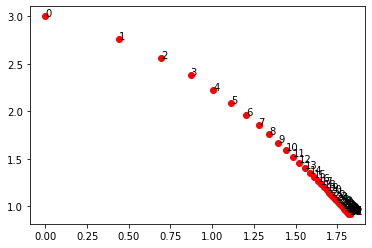

In [57]:
plot_2d_steps(steps,start).show()

Compare steepest descent with optimized step size:
![](images/steepest_descent.png)
*From Miettinen: Nonlinear optimization, 2007 (in Finnish)*

## Newton's method

Based on setting the search direction as $d_k=-[H(x_k)]^{-1}\nabla f(x_k).\hspace{2.0cm}$   --> **uses second derivatives!**

In one-dimensional case by the Taylor series:
$$f(x+\Delta x)\approx f(x)+f'(x)\Delta x+\frac12f''(x)\Delta x^2$$


We want to find $x$ such that $f(x)$ is at minimum and, thus, we seek to solve the equation that sets the derivative of this expression with respect to $\Delta x$ equal to zero (Necessary condition):

$$ 0 = \frac{d}{d\Delta x} \left(f(x_k)+f'(x_k)\Delta x+\frac 1 2 f''(x_k) \Delta x^2\right) = f'(x_k)+f'' (x_k) \Delta x.$$

The solution of the above equation is $\Delta x=-f'(x_k)/f''(x_k)$. Thus, the best approximation of $x_{k+1}$ as the minimum is $x_k-f''(x_k)^{-1}f'(x_k)$.


In [34]:
def newton(f,start,step,precision):
    f_old = float('Inf')
    x = np.array(start)
    steps = []
    f_new = f(x)
    while abs(f_old-f_new)>precision:
        f_old = f_new # store value of f at the current point
        H_inv = np.linalg.inv(np.matrix(ad.gh(f)[1](x))) # compute the inverse of the Hessian
        d = (-H_inv*(np.matrix(ad.gh(f)[0](x)).transpose())).transpose() # compute search direction
        #Change the type from np.matrix to np.array so that we can use it in our function
        x = np.array(x+d*step)[0] # take the step
        f_new = f(x) # compute function value at the new point
        steps.append(list(x)) # store step
    return x,f_new,steps

In [54]:
start = [2.0,-10.0]
step_size = 0.3
precision = 0.001
(x_value,f_value,steps) = newton(f_simple,start,step_size,precision)
print("Optimal solution is ",x_value)
print(len(steps))

Optimal solution is  [ 4.99003012 -5.01661647]
16


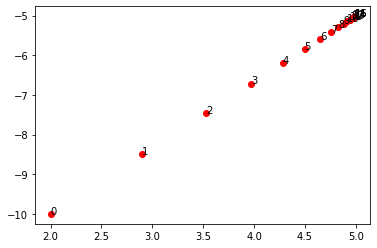

In [55]:
plot_2d_steps(steps,start).show()

## Another example

In [52]:
start = [0.0,3.0]
step_size = .3
precision = 0.001
(x_value,f_value,steps) = newton(f_simple2,start,step_size,precision)
print("Optimal solution is ",x_value)
print(len(steps))

Optimal solution is  [1.80304582 0.90269586]
22


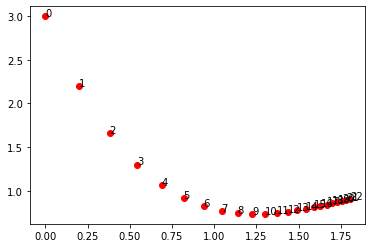

In [53]:
plot_2d_steps(steps,start).show()

Compare Newton's method with step size = 1.0:
![](images/newton.png)
*From Miettinen: Nonlinear optimization, 2007 (in Finnish)*

# Summary
Steepest descent
* Descent direction (does the search direction guarantee decrease in $f$): yes
* Global convergence (converges from any starting point): yes
* Local convergence: zig-zag near optimum
* Computational bottle neck: step length
* Memory consumption: $𝑂(𝑛)$

Newton’s method
* Descent direction: only if $𝐻(𝑥)^{−1}$ positive definite
* Global convergence: no
* Local convergence: yes, good if 𝑓 quadratic
* Computational bottle neck: $𝐻(𝑥 )^{−1}$ --> can be relaxed by using approximations of $H(x)^{-1}$ --> quasi-Newton
* Memory consumption: $𝑂(𝑛^2)$ --> can be reduced e.g. by using conjugate gradient methods